In [7]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from src.postproces_classificationresults import *
from src.plotting import *
from src.preproces import Handle_Files

import pickle

file_handler = Handle_Files()
model_name = 'LR'

# Results using SSP245 V SSP585

In [8]:
dict_dir = f'D:/Programmering/msc/Masterthesis_S23-Results/dicts/245V585/{model_name}'

with open('/'.join([dict_dir, f'classification_summaries_{model_name}_245v585_f1.pkl']), 'rb') as file:
    classification_summaries = pickle.load(file)

with open('/'.join([dict_dir, f'target_summaries_{model_name}_245v585_f1.pkl']), 'rb') as file:
    target_summaries = pickle.load(file)

with open('/'.join([dict_dir, f'roc_information_{model_name}_245v585_f1.pkl']), 'rb') as file:
    roc_information = pickle.load(file)

for dictionary in [classification_summaries, target_summaries, roc_information]:
    dictionary['supervised_features'] = dictionary.pop('johannes_supervised_features')

# Performance development

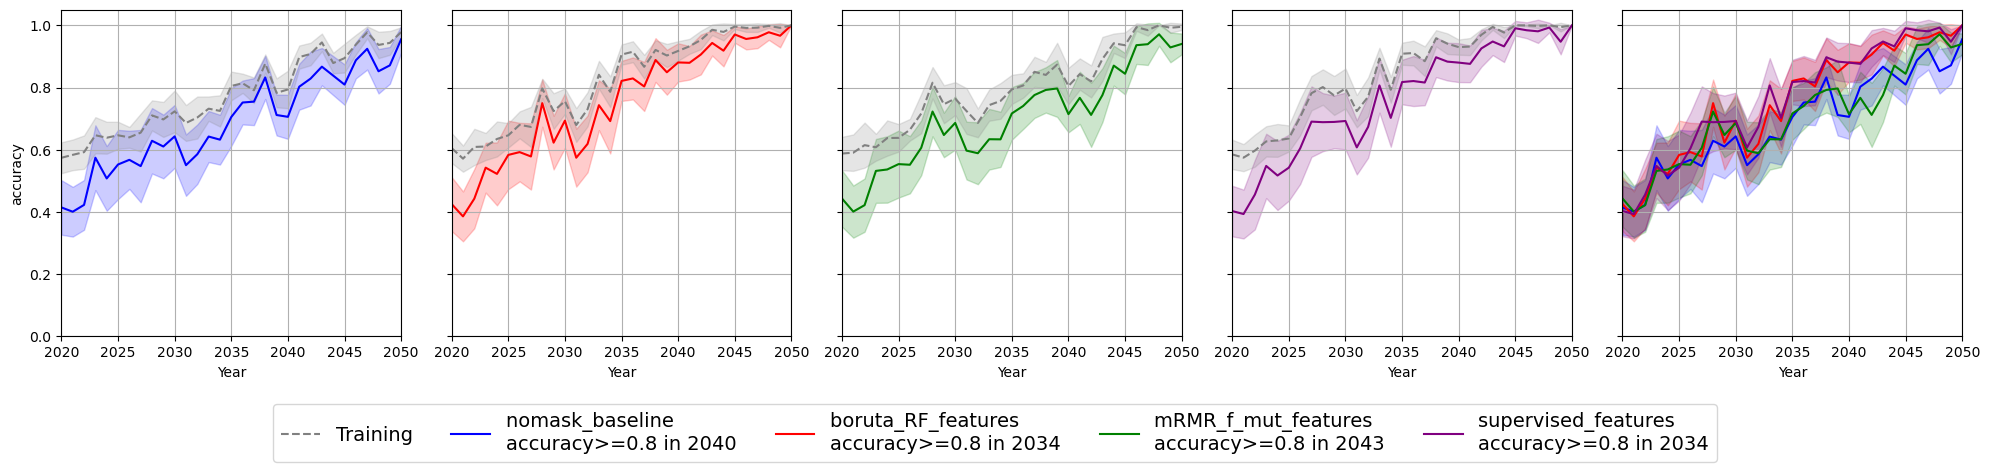

In [9]:
plot_performance(classification_summaries, metric='accuracy', years=list(range(2020, 2051)), 
                 model_name='Gaussian Naive Bayes classifier', spread=True, 
                 summary_subplot_for_spread=True, 
                 include_train=True, 
                 report_crossing=True, 
                 notitle=True,
                 turn_on_subplot_legend=False,)

# ROC and AUC analysis

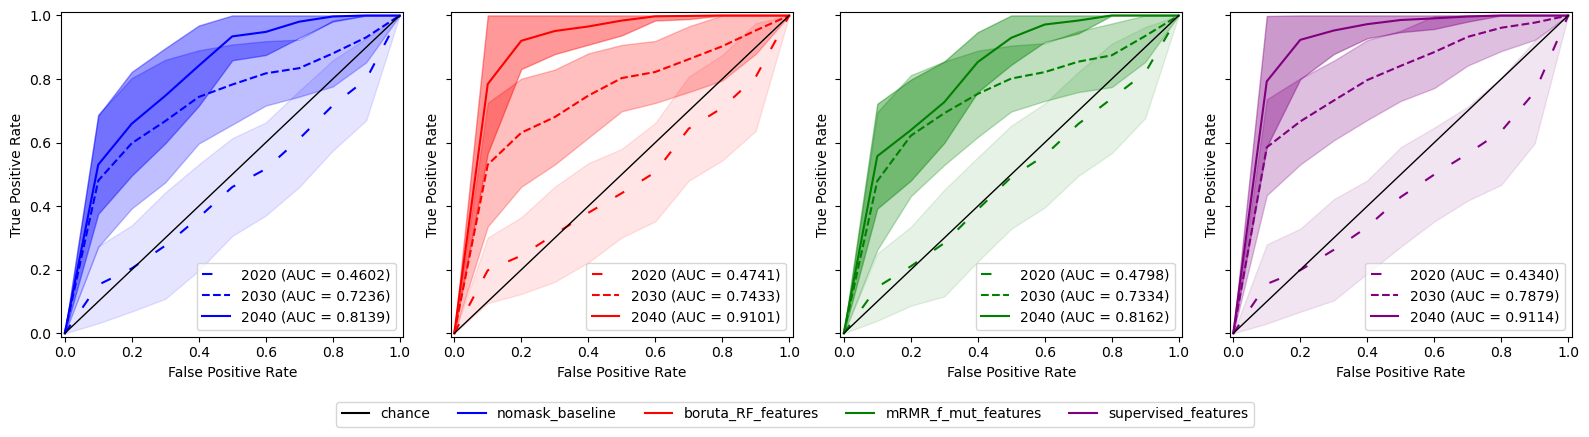

In [10]:
plot_roc_curve(roc_information, years=[2020, 2030, 2040], 
               model_name='Logistic Regression', title=None, 
               spread=True, summary_subplot_for_spread=False,
               notitle=True,
)

# Table representation

In [11]:
accuracy_df_long = create_plotdata_from_summary(classification_summaries, 'accuracy', years=list(range(2020, 2051)), include_train=True)
f1_df_long = create_plotdata_from_summary(classification_summaries, 'f1-score', years=list(range(2020, 2051)), include_train=True)

summary_df_acc = accuracy_df_long[accuracy_df_long['Year'].between(2035, 2040)].groupby(['feature_comb_key']).mean().reset_index()
summary_df_acc = summary_df_acc[['feature_comb_key', 'accuracy', 'training_accuracy']]
summary_df_acc.columns = ['feature_comb_key', 'accuracy test', 'accuracy training']

summary_df_f1 = f1_df_long[f1_df_long['Year'].between(2035, 2040)].groupby(['feature_comb_key']).mean().reset_index()
summary_df_f1 = summary_df_f1[['feature_comb_key', 'f1-score', 'training_f1-score']]
summary_df_f1.columns = ['feature_comb_key', 'f1-score test', 'f1-score training']

summary_df = summary_df_acc.merge(summary_df_f1, on='feature_comb_key')
for col in summary_df.columns:
    if col != 'feature_comb_key':
        summary_df[col] = summary_df[col].round(4)

print(summary_df)

# or 

accuracy_df_long = create_plotdata_from_summary(classification_summaries, 'accuracy', years=list(range(2020, 2051)), include_train=True)
print(accuracy_df_long.columns)

mean = accuracy_df_long[accuracy_df_long['Year'].between(2035, 2040)].groupby(['feature_comb_key']).mean().reset_index()
sd = accuracy_df_long[accuracy_df_long['Year'].between(2035, 2040)].groupby(['feature_comb_key']).std().reset_index()

for df in [mean, sd]:
    for col in df.columns:
        if col != 'feature_comb_key':
            df[col] = df[col].round(2)

summary_df_acc = mean.merge(sd, on='feature_comb_key', suffixes=('_mean', '_sd'))
summary_df_acc['estimated classification accuracy'] = '$' + summary_df_acc['accuracy_mean'].astype(str) + '\pm ' + summary_df_acc['accuracy_sd'].astype(str) +'$'

#summary_df_acc = summary_df_acc[['feature_comb_key', 'accuracy', 'training_accuracy']]

summary_df_acc = summary_df_acc[['feature_comb_key', 'estimated classification accuracy']]
summary_df_acc

      feature_comb_key  accuracy test  accuracy training  f1-score test  \
0   boruta_RF_features         0.8453             0.9048         0.8384   
1  mRMR_f_mut_features         0.7561             0.8283         0.7600   
2      nomask_baseline         0.7436             0.8105         0.7469   
3  supervised_features         0.8525             0.9221         0.8451   

   f1-score training  
0             0.9069  
1             0.8414  
2             0.8227  
3             0.9231  
Index(['Year', 'accuracy', 'feature_comb_key', 'training_accuracy'], dtype='object')


,feature_comb_key,estimated classification accuracy
0,boruta_RF_features,$0.85\pm 0.08$
1,mRMR_f_mut_features,$0.76\pm 0.08$
2,nomask_baseline,$0.74\pm 0.09$
3,supervised_features,$0.85\pm 0.08$


# Used hyperparameters

This performance was acchived using these models:

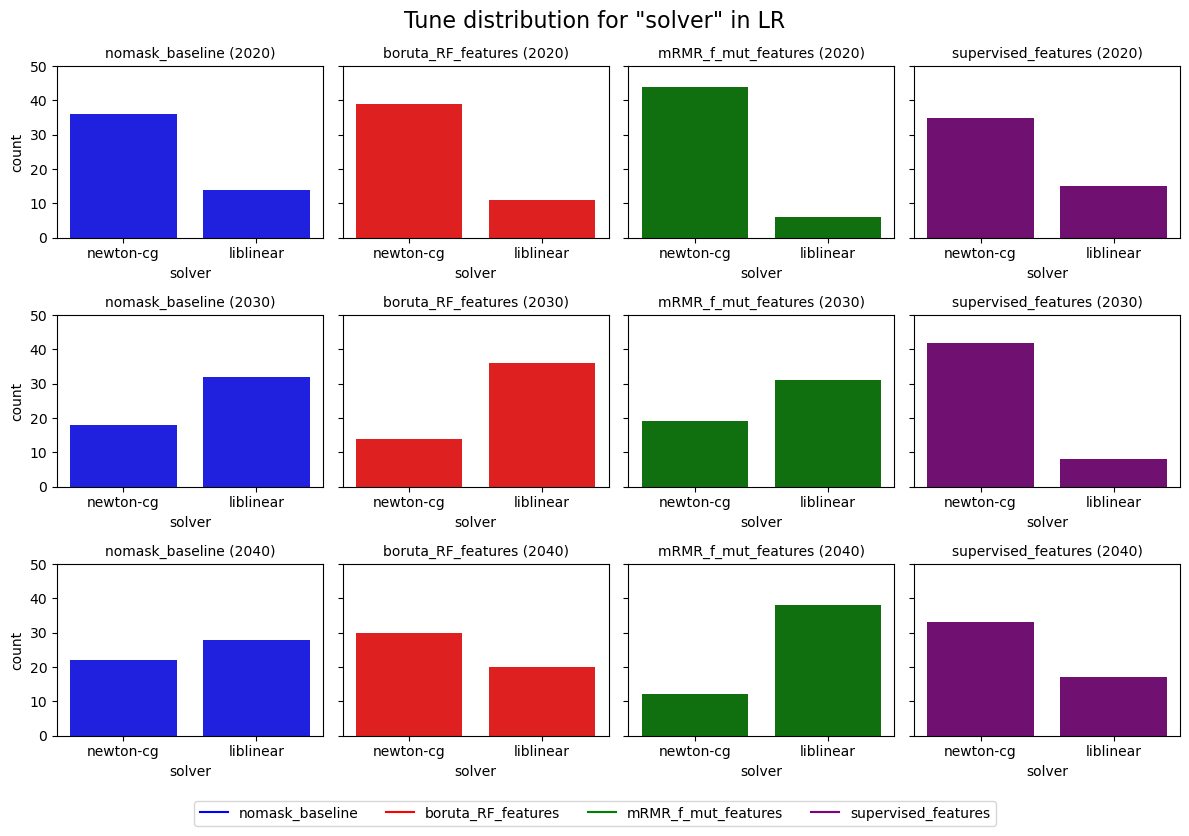

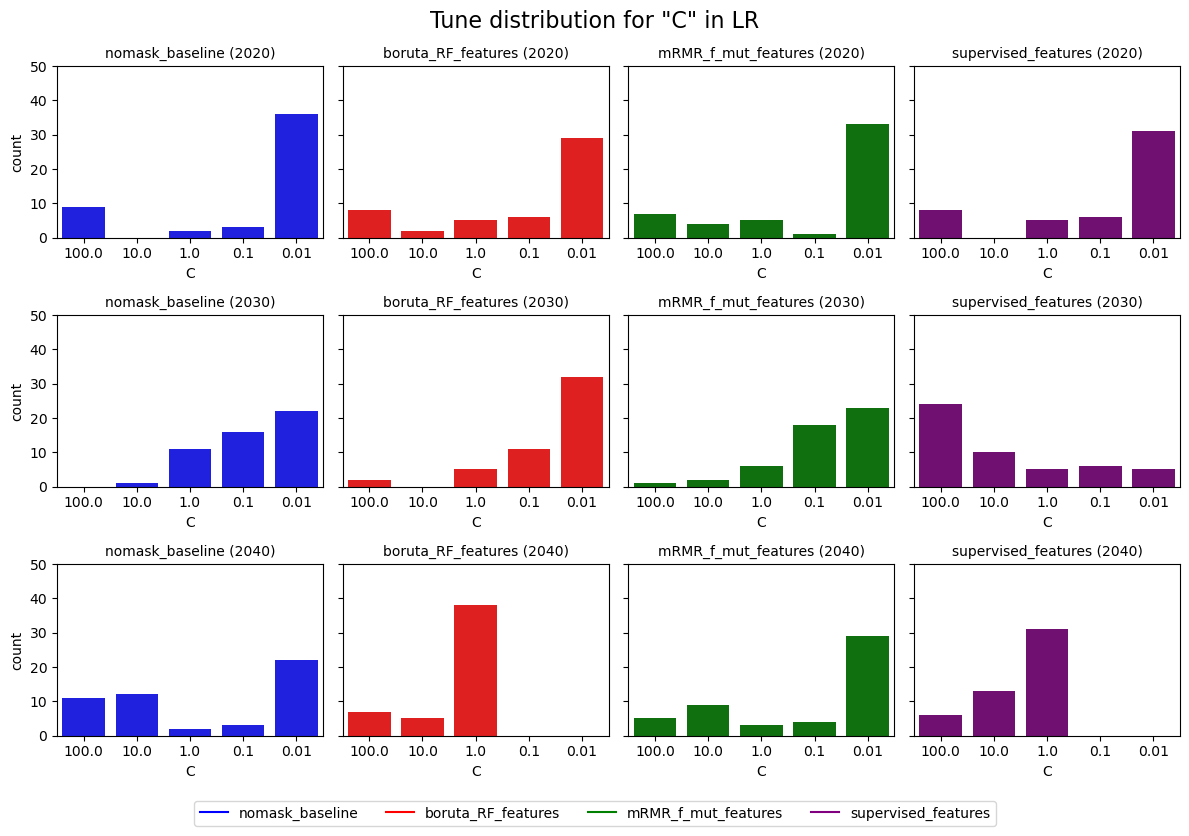

In [12]:
param_grid = {
        'solver': ['newton-cg', 'liblinear'],
        'penalty': ['l2'],
        'C': [100, 10, 1.0, 0.1, 0.01]
    }

plot_hyperparameters(target_summaries, model_name, years=[2020, 2030, 2040], param_grid=param_grid)

LISTeresting


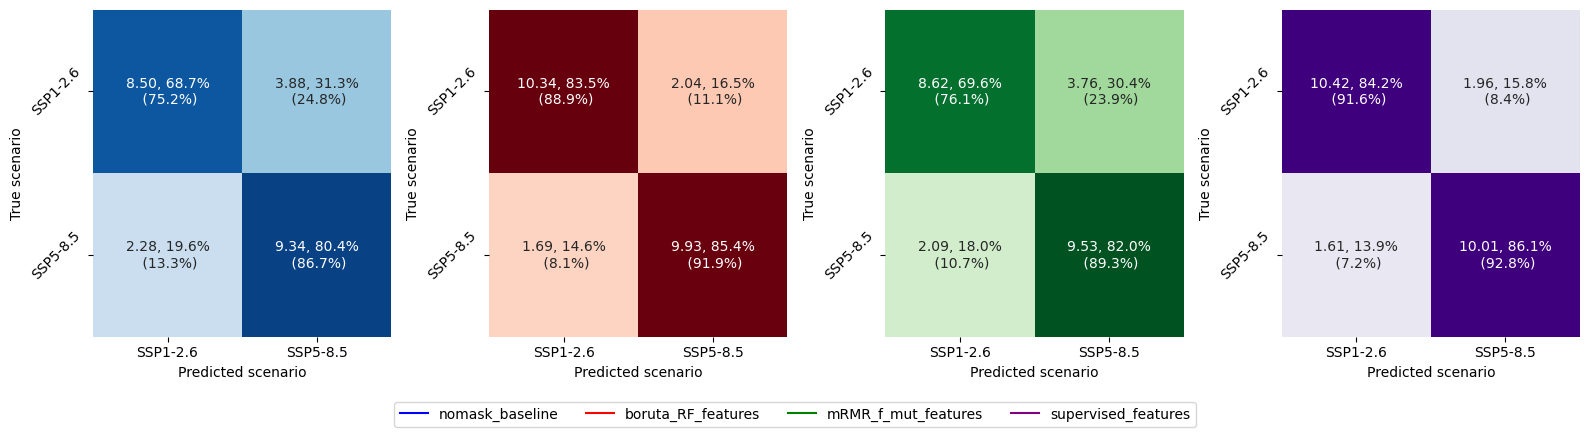

In [13]:
plot_cms(
    target_summaries, 
    model_name='Gaussian Naive Bayes classifier',
    report_performance=list(range(2035, 2041)),
    notitle=True,
    )

# Assessing the feature combinations

In [1]:
from src.helperfunctions_ML import open_cross_sections
import pandas as pd
import numpy as np
from statsmodels.multivariate.manova import MANOVA
import statsmodels.api as sm
from statsmodels.formula.api import ols

import itertools
from tqdm import tqdm

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
scenario_indx_key = {'ssp245': 0, 'ssp585': 1}
cross_sections = open_cross_sections(scenario_indx_key, scaled=False)

In [3]:
GSAT = ['tas: nomask']
nomask_features = ['fdETCCDI: nomask', 'gslETCCDI: nomask', 'pr: nomask', 'tas: nomask', 'txxETCCDI: nomask', 'rx5dayETCCDI: nomask']
boruta_RF_features = ['pr: nomask', 'pr: sea_mask', 'tas: land_mask', 'tas: nomask', 'tas: sea_mask', 'txxETCCDI: land_mask', 'txxETCCDI: nomask', 'txxETCCDI: sea_mask']
mRMR_f_mut_features = ['fdETCCDI: nomask', 'gslETCCDI: nomask', 'tas: land_mask', 'tas: nomask', 'tas: sea_mask', 'txxETCCDI: land_mask', 'txxETCCDI: lat_mask_pm30deg', 'txxETCCDI: nomask', 'txxETCCDI: sea_mask', 'txxETCCDI: sea_mask_pm30deg']
johannes_supervised_features = ['fdETCCDI: nomask', 'pr: nomask', 'pr: sea_mask', 'rx5dayETCCDI: land_mask', 'tas: nomask', 'txxETCCDI: sea_mask']

feature_combinations = {
    'GSAT': GSAT,
    'nomask_baseline': nomask_features, 
    'boruta_RF_features': boruta_RF_features,
    'mRMR_f_mut_features': mRMR_f_mut_features,
    'supervised_features': johannes_supervised_features
}

years = np.linspace(2015, 2050, (2050-2015)+1, dtype=int)

def preprocess_for_anova(df, factors, variables):

    new_variable_names = [str.replace(': ', '_') for str in variables]
    df.rename(columns=dict(zip(variables, new_variable_names)), inplace=True)

    df = df.loc[:, factors + new_variable_names]  # Keep only columns in factors or variables

    for variable in new_variable_names:
        df[variable] = df[variable].astype(np.float32)
        
    for factor in factors:
        df[factor] = df[factor].astype('category')
    
    return df, new_variable_names

In [4]:
p_values_df = pd.DataFrame(columns=['Year', 'Feature combination', 'Wilks Lambda'],#, 'Pillai\'s Trace'], 
                           index=range(len(feature_combinations)*len(years)))
indx = 0
for year in years:
    cross_section = cross_sections[year]
    for feature_combination_name, features in feature_combinations.items():

        df, new_variable_names = preprocess_for_anova(cross_section, factors=['scenario'], variables=features)

        var_comb_str = '+'.join(new_variable_names)  +'~ scenario'

        if feature_combination_name == 'GSAT':
            model = ols(var_comb_str, data=df).fit()
            aov_table = sm.stats.anova_lm(model, typ=2) 
            
            p_val = aov_table['PR(>F)'].iloc[0]
        else:
            manova_results = MANOVA.from_formula(var_comb_str, data=df)
            # get the p-value for the Wilks' Lambda
            p_val = manova_results.mv_test().results['scenario']['stat']['Pr > F'].iloc[0]
        
        p_values_df.loc[indx] = [year, feature_combination_name, p_val] #, pillaistrace]
        indx += 1

p_values_df


,Year,Feature combination,Wilks Lambda
0,2015,GSAT,0.908563
1,2015,nomask_baseline,0.935467
2,2015,boruta_RF_features,0.949628
3,2015,mRMR_f_mut_features,0.852734
4,2015,supervised_features,0.934289
...,...,...,...
175,2050,GSAT,0.0
176,2050,nomask_baseline,0.0
177,2050,boruta_RF_features,0.0
178,2050,mRMR_f_mut_features,0.0


In [5]:
def last_observation_above_threshold(df, threshold):
    
    report = {}
    for feature_comb in df['Feature combination'].unique():
        
        feature_comb_df = df[df['Feature combination'] == feature_comb]
        last_observation = np.where(feature_comb_df['Wilks Lambda'] > threshold)[0][-1] # this is the index of the last year where p > 0.05
        first_year_bellow_threshold = feature_comb_df.iloc[last_observation]['Year'] + 1 # this is the first year where p < 0.05

        report[feature_comb] = first_year_bellow_threshold
        
    return report

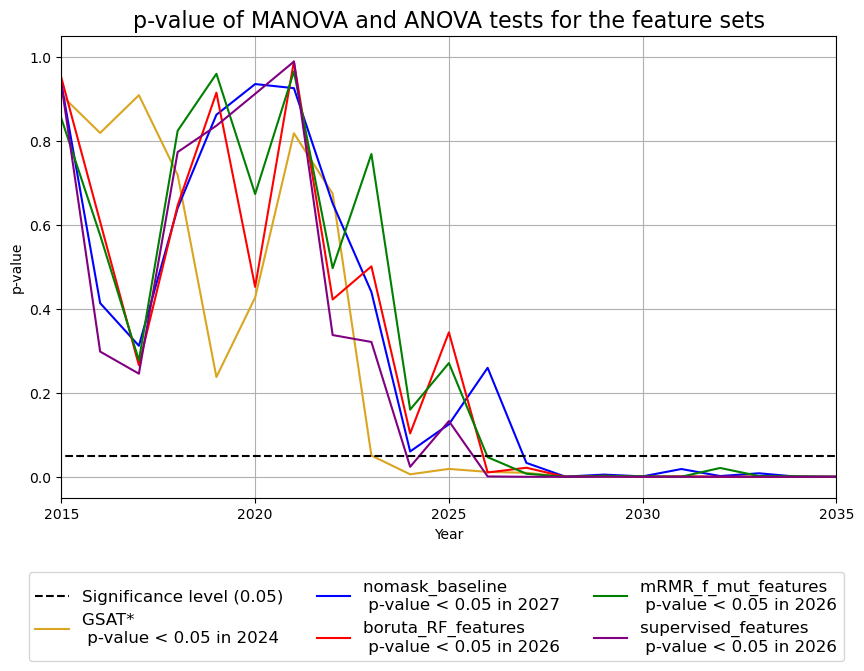

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

full_palette = ['goldenrod', 'blue', 'red', 'green', 'purple',]
fig, ax = plt.subplots(figsize=(10, 6))


sns.lineplot(
    data=p_values_df, 
    x='Year', 
    y='Wilks Lambda', 
    hue='Feature combination', 
    palette=full_palette,
    ax=ax,
    legend=False
    )

ax.set_ylim(-0.05, 1.05)
ax.set_xlim(2015, 2035)
ax.set_xticks(range(2015, 2036, 5))
ax.set_ylabel('p-value')
ax.set_title('p-value of MANOVA and ANOVA tests for the feature sets', fontsize=16)
ax.hlines(0.05, xmin=2010, xmax=2035, linestyle='--', color='black', label='Significance level (0.05)')
ax.grid(True)

last_observation_above_threshold = last_observation_above_threshold(p_values_df, 0.05)

labels = ['Significance level (0.05)']+[f"{key} \n p-value < 0.05 in {crossing_year}" for key, crossing_year in last_observation_above_threshold.items()]
labels[1] = labels[1].replace('GSAT', 'GSAT*')
handles = [plt.Line2D([0], [0], color=color, label=label, linestyle='dashed' if i == 0 else 'solid') for i, (color, label) in enumerate(zip(['black']+full_palette, labels))]
fig.legend(
    handles=handles, 
    loc='upper center', 
    bbox_to_anchor=(0.5, 0), 
    ncols=3,
    fontsize=12
    )  # Put the legend below the plot

plt.show()